In [1]:
from pathlib import Path
thispath = Path.cwd().resolve()
import sys; sys.path.insert(0, str(thispath.parent))

from general_utils.plots import plot_detections
from deep_learning.models.class_based_detector import ClassificationBasedDetector
from deep_learning.models.base_classifier import CNNClasssifier
import general_utils.utils as utils
from database.dataset import INBreast_Dataset

import torch
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torchvision import models

In [2]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    extract_patches=False,
    partitions = ['validation'],
    lesion_types = ['calcification', 'cluster'],
    cropped_imgs = True,
    keep_just_images_of_lesion_type = False,
    use_muscle_mask=False,
    ignore_diameter_px = 15
)

In [3]:
# model definition
model_path = '/home/jseia/Desktop/ml-dl/data/dl_runs/resnet50_02/resnet50_02.pt'
model_ckpt = torch.load(model_path)
cfg = model_ckpt['configuration']
model = CNNClasssifier(
    activation=getattr(nn, cfg['model']['activation'])(),
    dropout=cfg['model']['dropout'],
    fc_dims=cfg['model']['fc_dims'],
    freeze_weights=cfg['model']['freeze_weights'],
    backbone=cfg['model']['backbone'],
    pretrained=cfg['model']['pretrained'],
)
model = model.model
model.load_state_dict(model_ckpt['model_state_dict'])
for param in model.parameters():
    param.requires_grad = False

In [4]:
# detector instatiation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()
detector = ClassificationBasedDetector(
    model,
    threshold=0,
    pred_kind='score',
    norm_kind='avg',
    post_proc=True,
    patch_size=224,
    stride=25,
    min_breast_fraction_patch=0.5,
    batch_size=24,
    device=device,
    nms=True,
    iou_threshold=0.2)

In [5]:
def get_tp_fp_fn_center_patch_criteria(
    candidates: np.ndarray, roi_mask: np.ndarray, center_region_size: int, patch_size: int,
    use_euclidean_dist: bool = False, scores_passed: bool = False
):
    """
    Given an array of candidates and the mask of labels, it computes the itersection of a
    patch of patch_size centered on each candidate and -if the center crop of center_regio_size
    inside that patch matches a lesion in the gt mask- its counted as a tp if not as a fp.
    If center_region_size is None, then the intersection on the original patch is computed.
    At the end it gets the labels that weren't matched (FN).
    The returned dataframe for TP containes duplicated detections, for the cases in whic one
    detection matches more than one label. To include them in the sentivity metrics and to
    make an easier computation of froc NMS this duplicates are kept. If they are not desired
    performing a drop_duplicates(subset=['repeted_idxs']) will do the job.
    Args:
        candidates (np.ndarray): [x, y, radius]
        roi_mask (np.ndarray): mask of lesion labels (each one identified independently)
        center_region_size (int): region in the center of the patch to consider for labeling.
            If set to None the hole patch is considered for the intersection.
        patch_size (int): size of the patch to evaluate
        use_euclidean_dist (bool): whether to use euclidean distance (True - aka circular patch)
            or p=infinity minkowsky distance (False - aka rectangular patch), between the center
            of the detect candidate and the closest point of sorrounding ground truth labels.
            Defaults to False
        scores_passed: if the scores are already available and included in the candidates array
    Returns:
        tp (pd.DataFrame): Columns: ['x', 'y', 'radius', 'label', 'matching_gt','repeted_idxs']
        fp (pd.DataFrame): Columns: ['x', 'y', 'radius', 'label', 'matching_gt','repeted_idxs']
        fn (pd.DataFrame): Columns: ['x', 'y', 'radius', 'label', 'matching_gt','repeted_idxs']
        ignored_candidates (pd.DataFrame):
            Columns: ['x', 'y', 'radius', 'label', 'matching_gt','repeted_idxs']
    """
    ignored_candidates, tp, fp, fn = [], [], [], []
    matching_gt, repeted_tp, repeted_fp = [], [], []
    if use_euclidean_dist:
        if patch_size % 2 == 0:
            patch_size = patch_size + 1
        center = patch_size//2
        circular_mask = np.zeros((patch_size, patch_size), dtype='uint8')
        circular_mask = cv2.circle(
            circular_mask, center=(center, center), radius=center, color=1, thickness=-1)
    detected_labels = set()
    tp_count, fp_count = 0, 0
    for coords in candidates:
        # getting patch coordinates
        patch_x1, patch_x2, patch_y1, patch_y2 = utils.patch_coordinates_from_center(
            (int(coords[0]), int(coords[1])), roi_mask.shape, patch_size)

        # getting coordinates of the patch center. Necessary if the patch is
        # in border and shifted
        if center_region_size is not None:
            p_center_y = patch_y1 + (patch_y2 - patch_y1)//2
            p_center_x = patch_x1 + (patch_x2 - patch_x1)//2
            patch_x1, patch_x2, patch_y1, patch_y2 = utils.patch_coordinates_from_center(
                (p_center_x, p_center_y), roi_mask.shape, center_region_size)

        # Get the overlap with the rois mask and determine the unique labels
        overlap_on_labels = roi_mask[patch_y1:patch_y2, patch_x1:patch_x2]
        if use_euclidean_dist:
            overlap_on_labels = overlap_on_labels * circular_mask
        unique_labels = [label for label in np.unique(overlap_on_labels) if label != 0]
        detected_labels.update(set(unique_labels))
        intersection = (overlap_on_labels > 0).any()
        just_label_to_ignore_matched = (overlap_on_labels < 0).any()

        # If there's intersection repeat the candidate for each gt that it matched
        # This will help a faster NMS and correct computation of metrics
        if intersection:
            count = 0
            for label in unique_labels:
                tp.append(coords)
                matching_gt.append(label)
                # Keep which ones are repeted to avoid feature extraction later
                repeted_tp.append(tp_count)
                count += 1
            tp_count += count
        elif just_label_to_ignore_matched:
            ignored_candidates.append(coords)
        else:
            fp.append(coords)
            repeted_fp.append(fp_count)
            fp_count += 1

    # Obtain the false negatives
    detected_labels = list(detected_labels)
    gt_labels = np.unique(roi_mask)
    for label in gt_labels:
        if (label == 0) or (label in detected_labels):
            continue
        y, x = np.where(roi_mask == label)
        y1, y2 = y.min(), y.max()
        x1, x2 = x.min(), x.max()
        w, h = x2 - x1, y2 - y1
        center_x = x1 + w//2
        center_y = y1 + h//2
        radius_aprox = np.maximum(w, h) / 2
        if scores_passed:
            score = None
            fn.append((center_x, center_y, radius_aprox, score))
        else:
            fn.append((center_x, center_y, radius_aprox))

    # Generate the resulting dataframe
    colnames = ['x', 'y', 'radius', 'score'] if scores_passed else ['x', 'y', 'radius']
    tp = pd.DataFrame(tp, columns=colnames)
    tp['label'] = 'TP'
    tp['repeted_idxs'] = repeted_tp
    tp['matching_gt'] = matching_gt

    fp = pd.DataFrame(fp, columns=colnames)
    fp['label'] = 'FP'
    fp['repeted_idxs'] = np.asarray(repeted_fp) + len(tp)
    fp['matching_gt'] = None

    fn = pd.DataFrame(fn, columns=colnames)
    fn['label'] = 'FN'
    fn['matching_gt'] = None
    fn['repeted_idxs'] = False

    ignored_candidates = pd.DataFrame(ignored_candidates, columns=colnames)
    ignored_candidates['label'] = 'ignored'
    ignored_candidates['matching_gt'] = None
    ignored_candidates['repeted_idxs'] = False

    return tp, fp, fn, ignored_candidates

In [6]:
import cv2

In [27]:
from tqdm import tqdm
from metrics.metrics_utils import get_froc_df_of_img
import pandas as pd

normal_imgs_ids = db.get_free_of_selected_lesions_imgs_ids()

froc_dfs = []
for idx in tqdm(range(20)):
    db_sample = db[idx]
    image = db_sample['img']
    image_id = db_sample['img_id']
    image_mask = db_sample['lesion_mask']

    # # get detections:
    detections = detector.detect(image)
    detections_centers = detections[:, 0:2].astype(int)
    detections_scores = detections[:, -1].reshape(-1, 1)
    detections_radius = np.ones(detections_scores.shape) * 7

    # retain the centers and scores:
    candidates = np.concatenate([detections_centers, detections_radius, detections_scores], axis = 1)

    # compare with labels
    tp, fp, fn, ignored_candidates = get_tp_fp_fn_center_patch_criteria(
        candidates, image_mask, None, 14, use_euclidean_dist=True, scores_passed=True)

    # compare with labels
    candidates = pd.concat([tp, fp], axis=0, ignore_index=True)
    labels = np.where(candidates.label.values == 'TP', True, False)

    # Restore repeted detections and generate standar dataframe
    froc_df = get_froc_df_of_img(candidates, fn, candidates['score'], image_id, (image_id in normal_imgs_ids))
    froc_dfs.append(froc_df)

 10%|█         | 2/20 [04:36<41:32, 138.46s/it]


KeyboardInterrupt: 

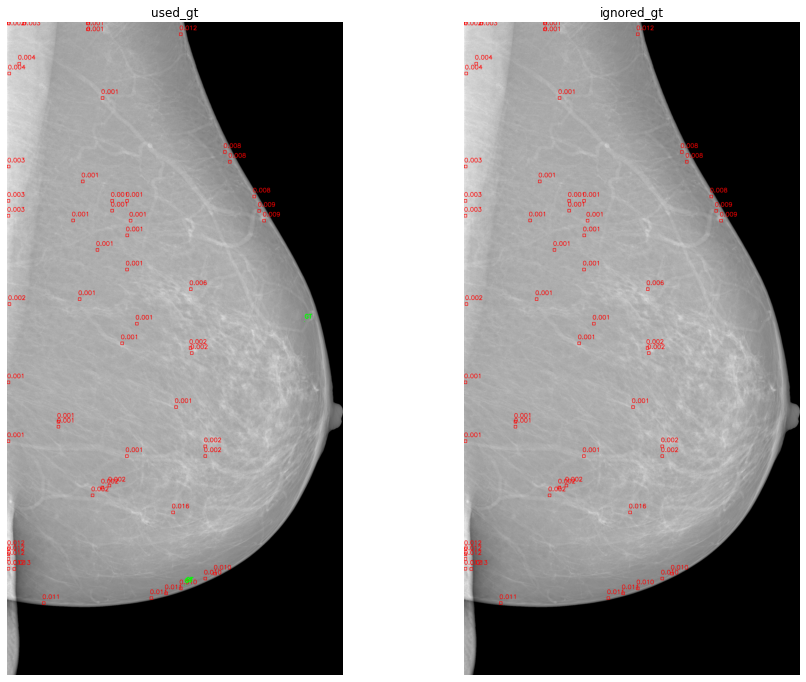

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 12))
plot_detections(detections[:, 2:], image, k=0, gt_bboxes=db_sample['lesion_bboxes'], ax=ax[0])
ax[0].set_title('used_gt')
plot_detections(detections[:, 2:], image, k=0, gt_bboxes=db_sample['ignored_lesion_bboxes'], ax=ax[1])
ax[1].set_title('ignored_gt')
plt.show()

In [14]:
orig_df = pd.read_csv('/home/jseia/Desktop/ml-dl/calc-det/data/INbreast Release 1.0/images_metadata.csv')

In [17]:
db.img_df.breast_bbox[0]

'[(984, 0), (2560, 2973)]'

In [15]:
db.img_df.columns

Index(['Unnamed: 0', 'img_id', 'n_rois', 'side', 'view', 'filename', 'acr',
       'artifact', 'birads', 'case_id', 'finding_notes', 'lesion_annot',
       'pectoral_muscle', 'mass', 'micros', 'distortion', 'asymmetry',
       'breast_bbox', 'partition', 'img_size', 'muscle_mask', 'case_label',
       'img_label'],
      dtype='object')

In [17]:
detections[:,2:].shape

(6, 5)

In [7]:
import SimpleITK as sitk
def save_detections_mask_dcm(
    detections: np.ndarray, original_dcm_path: Path, dst_filename: Path, breast_bbox: np.ndarray = None
):
    ref_itkimage = sitk.ReadImage(original_dcm_path)
    if breast_bbox is not None:
        original_shape = ref_itkimage.GetDimension() 
        segmentation = np.zeros(original_shape)
        segmentation = 
    ref_itkimage = sitk.ReadImage(original_dcm_path)
    origin = ref_itkimage.GetOrigin()
    spacing = ref_itkimage.GetSpacing()
    segmentation = sitk.GetImageFromArray(segmentation, isVector=False)
    segmentation.SetSpacing(spacing)
    segmentation.SetOrigin(origin)
    sitk.WriteImage(segmentation, filename)

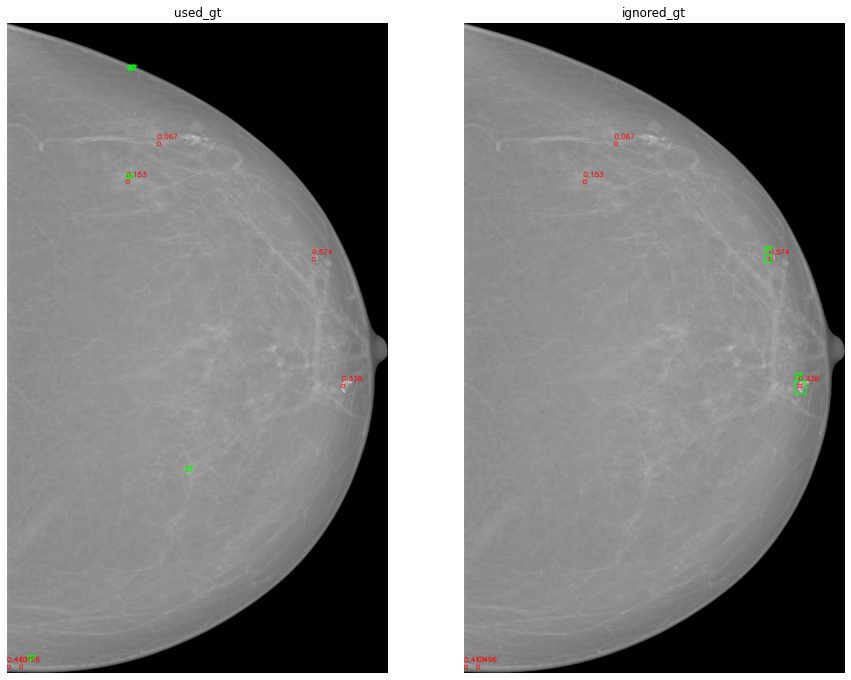

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(15, 12))
plot_detections(detections[:, 2:], image, k=0, gt_bboxes=db_sample['lesion_bboxes'], ax=ax[0])
ax[0].set_title('used_gt')
plot_detections(detections[:, 2:], image, k=0, gt_bboxes=db_sample['ignored_lesion_bboxes'], ax=ax[1])
ax[1].set_title('ignored_gt')
plt.show()

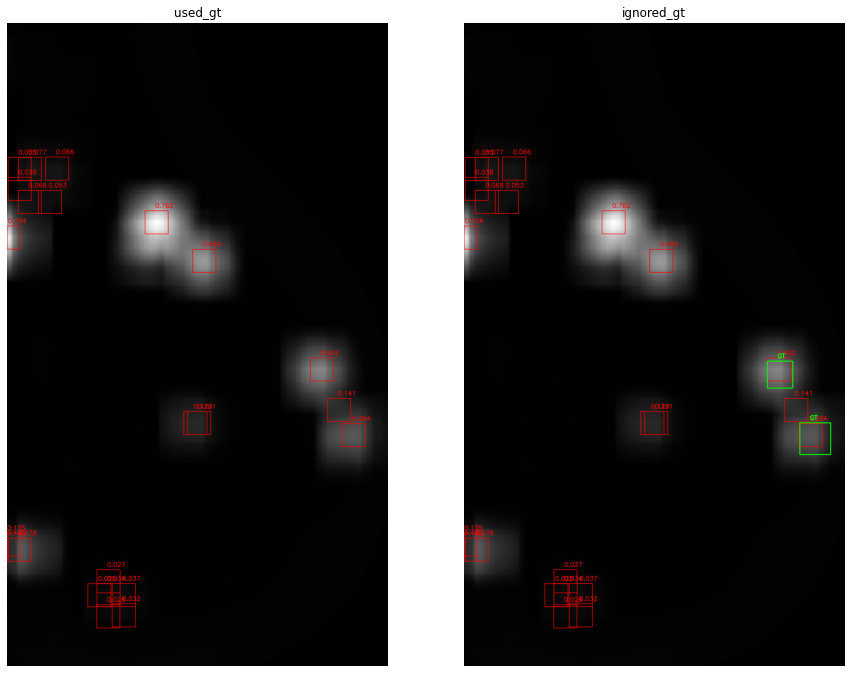

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(15, 12))
plot_detections(detections, detector.saliency_map, k=50, gt_bboxes=sample['lesion_bboxes'], ax=ax[0])
ax[0].set_title('used_gt')
plot_detections(detections, detector.saliency_map, k=50, gt_bboxes=sample['ignored_lesion_bboxes'], ax=ax[1])
ax[1].set_title('ignored_gt')
plt.show()

#### Effect of stride

100%|██████████| 34/34 [00:04<00:00,  7.05it/s]


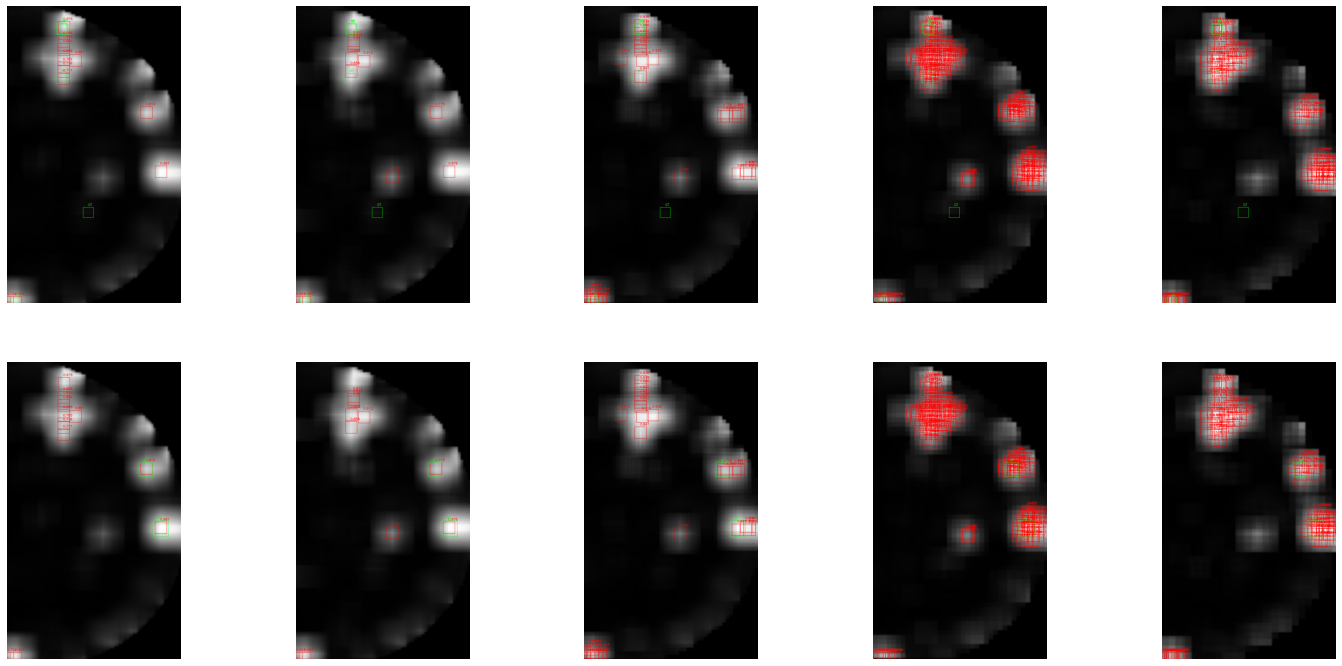

In [26]:
detector = ClassificationBasedDetector(
    model, threshold=0.4660137891769409, pred_kind='score', norm_kind='avg',
    post_proc=True, patch_size=224, stride=25, min_breast_fraction_patch=0.5,
    batch_size=24, device=device, nms=True, iou_threshold=0.2)

detections = {}
fig, ax = plt.subplots(2, 5, figsize=(25, 12))
for k, stride in enumerate([20, 25, 35, 45, 65], 0):
    detector.stride = stride
    detections[stride] = detector.detect(img)
    plot_detections(detections[stride], detector.saliency_map, k=50, gt_bboxes=sample['lesion_bboxes'], ax=ax[0, k])
    plot_detections(detections[stride], detector.saliency_map, k=50, gt_bboxes=sample['ignored_lesion_bboxes'], ax=ax[1, k])
plt.show()

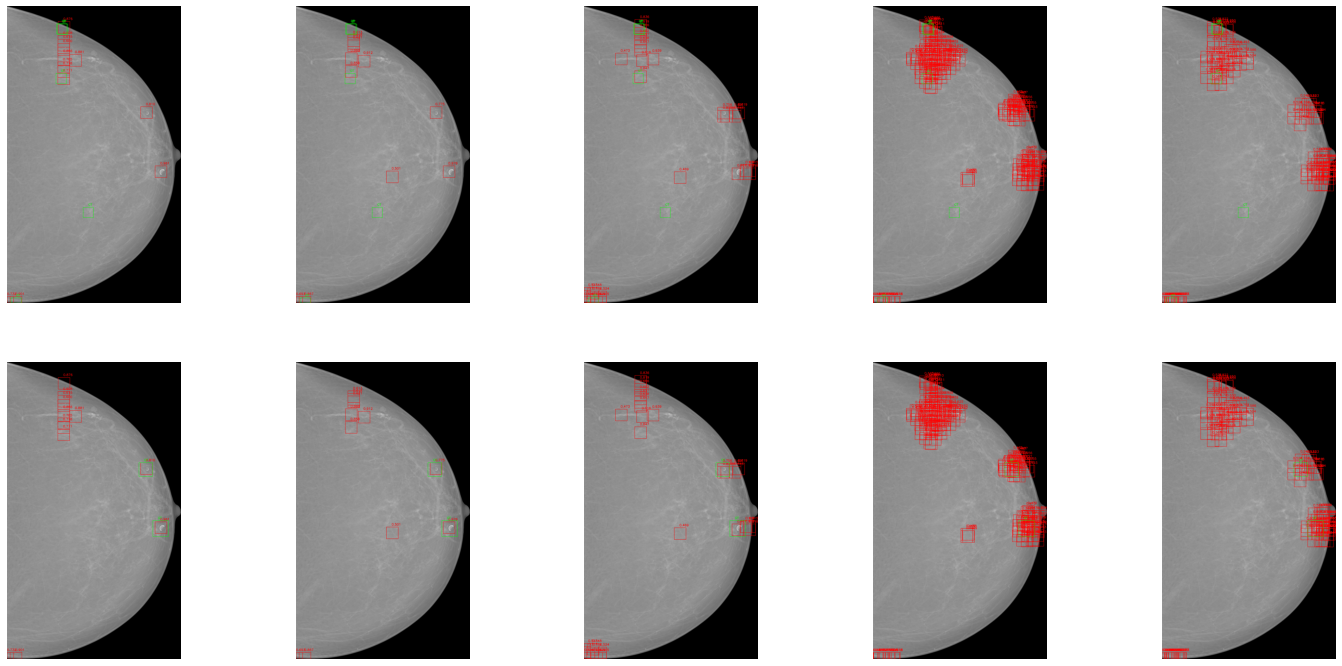

In [29]:
fig, ax = plt.subplots(2, 5, figsize=(25, 12))
for k, (stride, dets) in enumerate(detections.items(), 0):
    plot_detections(dets, img, k=50, gt_bboxes=sample['lesion_bboxes'], ax=ax[0, k])
    plot_detections(dets, img, k=50, gt_bboxes=sample['ignored_lesion_bboxes'], ax=ax[1, k])
plt.show()

#### Effect of smoothing

100%|██████████| 34/34 [00:05<00:00,  6.73it/s]


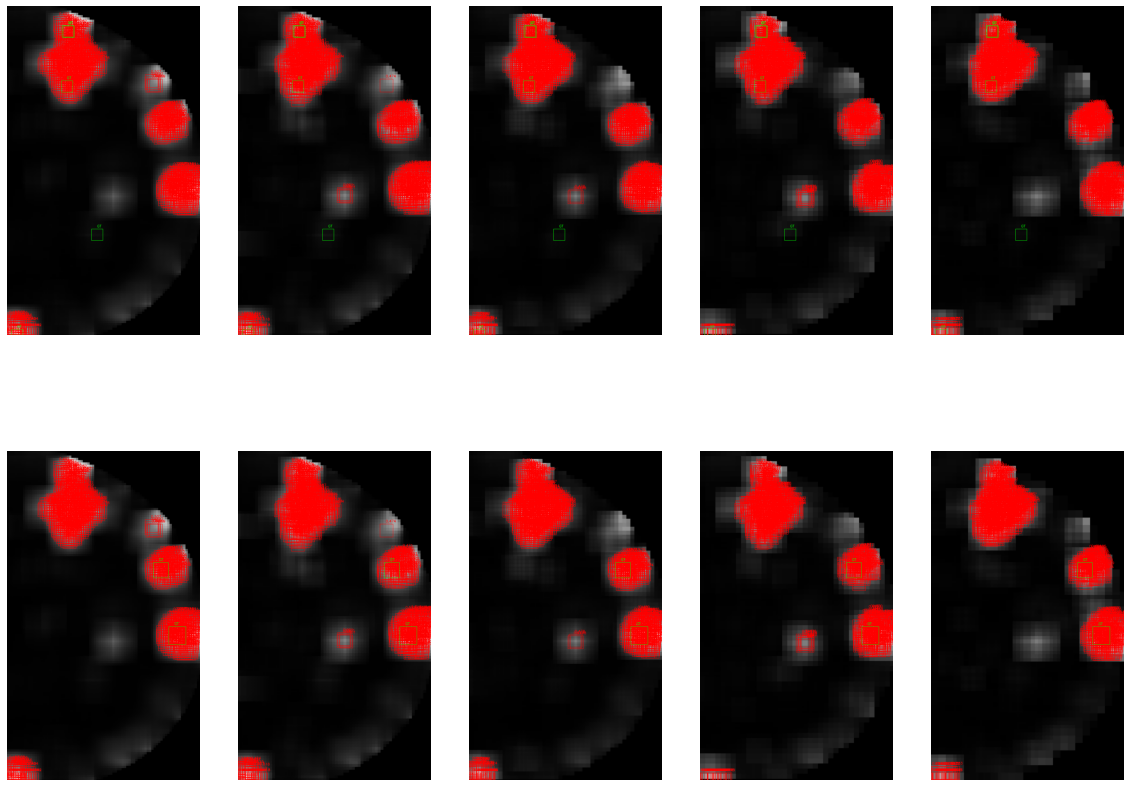

In [12]:
detector = ClassificationBasedDetector(
    model, threshold=0.4660137891769409, pred_kind='score', norm_kind='avg',
    post_proc=False, patch_size=224, stride=25, min_breast_fraction_patch=0.5,
    batch_size=24, device=device, nms=True, iou_threshold=0)

detections = {}
fig, ax = plt.subplots(2, 5, figsize=(20, 15))
for k, stride in enumerate([20, 25, 35, 45, 65], 0):
    detector.stride = stride
    detections[stride] = detector.detect(img)
    plot_detections(detections[stride], detector.saliency_map, k=50, gt_bboxes=sample['lesion_bboxes'], ax=ax[0, k])
    plot_detections(detections[stride], detector.saliency_map, k=50, gt_bboxes=sample['ignored_lesion_bboxes'], ax=ax[1, k])
plt.show()

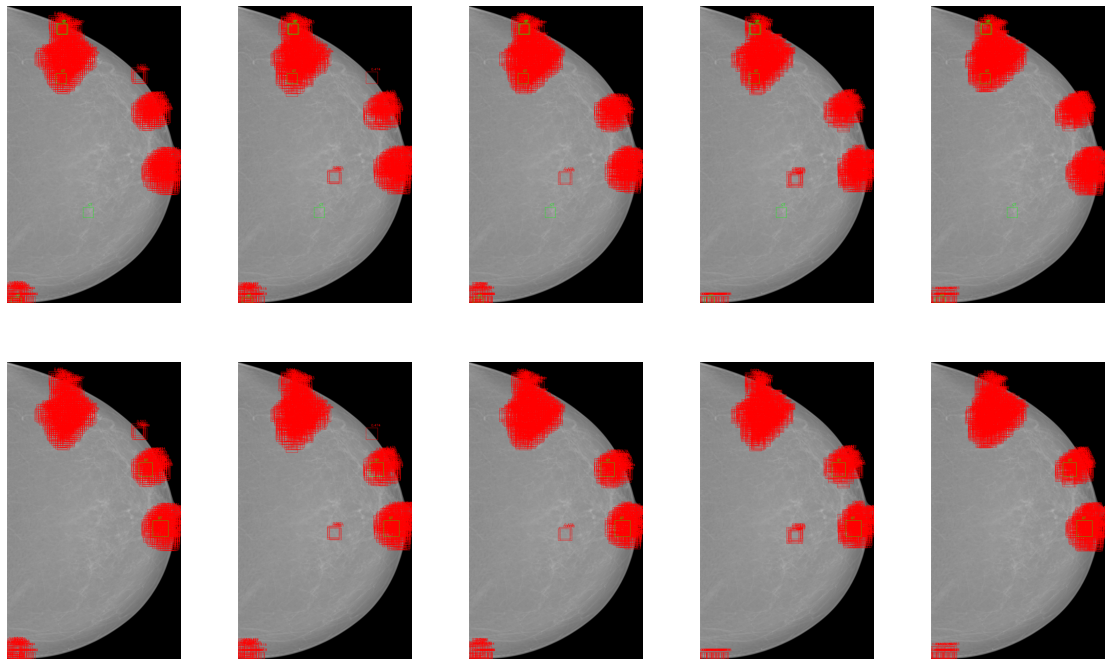

In [9]:
fig, ax = plt.subplots(2, 5, figsize=(20, 15))
for k, (stride, dets) in enumerate(detections.items(), 0):
    plot_detections(dets, img, k=50, gt_bboxes=sample['lesion_bboxes'], ax=ax[0, k])
    plot_detections(dets, img, k=50, gt_bboxes=sample['ignored_lesion_bboxes'], ax=ax[1, k])
plt.show()

#### Effect of normalization

100%|██████████| 34/34 [00:04<00:00,  6.81it/s]


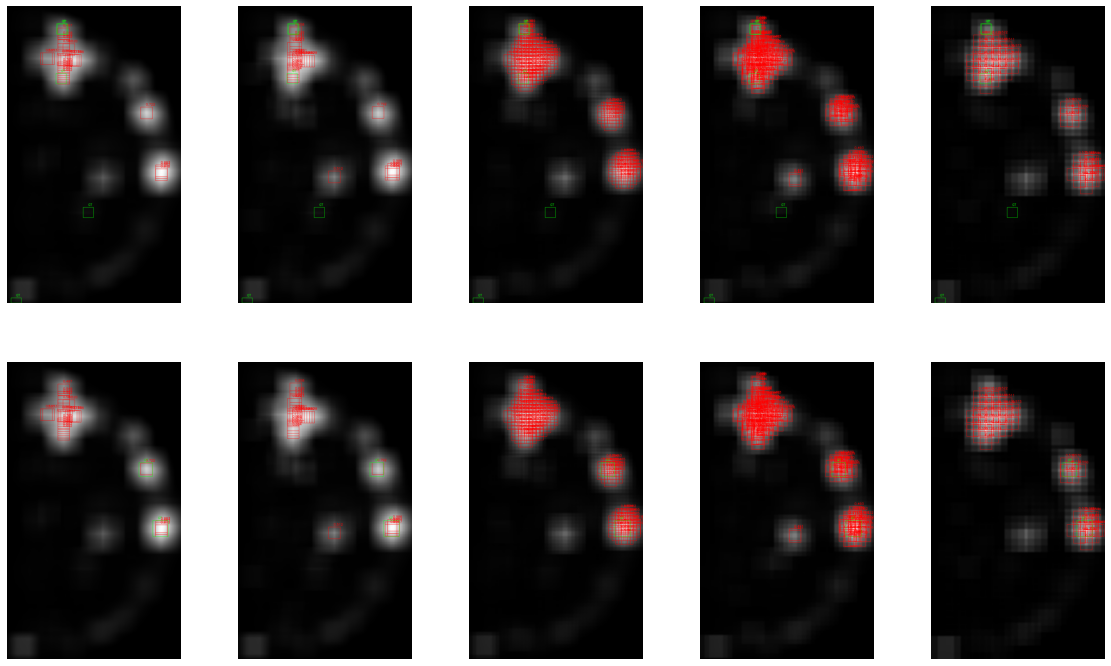

In [6]:
detector = ClassificationBasedDetector(
    model, threshold=0.4660137891769409, pred_kind='score', norm_kind='min_max',
    post_proc=True, patch_size=224, stride=25, min_breast_fraction_patch=0.5,
    batch_size=24, device=device, nms=True, iou_threshold=0.2)

detections = {}
fig, ax = plt.subplots(2, 5, figsize=(20, 12))
for k, stride in enumerate([20, 25, 35, 45, 65], 0):
    detector.stride = stride
    detections[stride] = detector.detect(img)
    plot_detections(detections[stride], detector.saliency_map, k=50, gt_bboxes=sample['lesion_bboxes'], ax=ax[0, k])
    plot_detections(detections[stride], detector.saliency_map, k=50, gt_bboxes=sample['ignored_lesion_bboxes'], ax=ax[1, k])
plt.show()

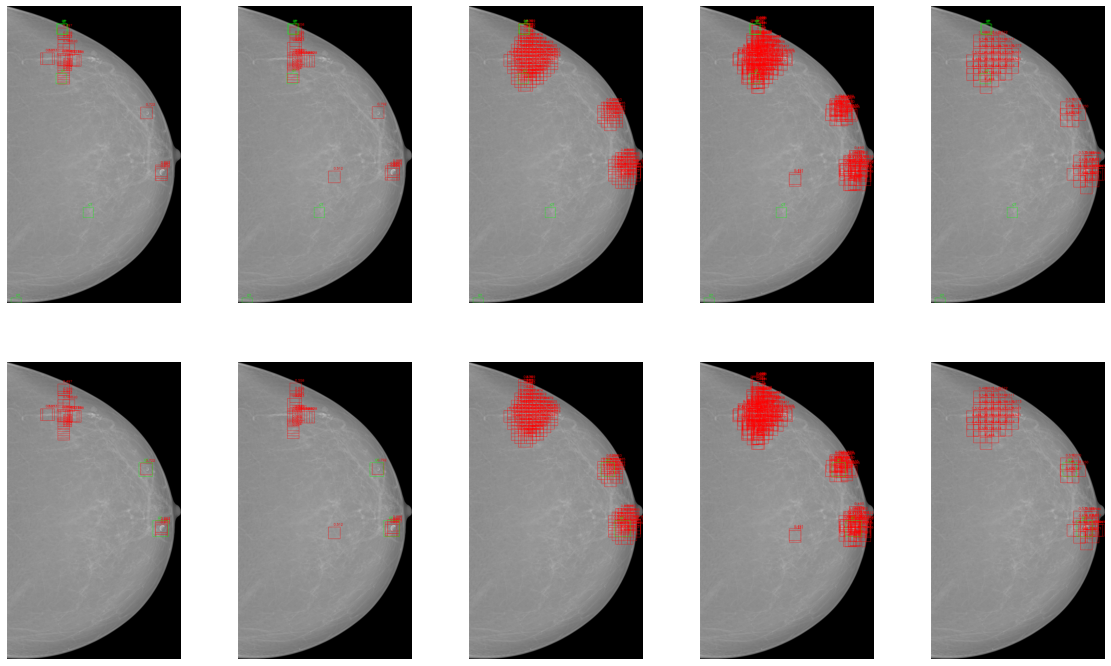

In [7]:
fig, ax = plt.subplots(2, 5, figsize=(20, 12))
for k, (stride, dets) in enumerate(detections.items(), 0):
    plot_detections(dets, img, k=50, gt_bboxes=sample['lesion_bboxes'], ax=ax[0, k])
    plot_detections(dets, img, k=50, gt_bboxes=sample['ignored_lesion_bboxes'], ax=ax[1, k])
plt.show()

#### Effect of prediction kind

100%|██████████| 34/34 [00:04<00:00,  6.97it/s]


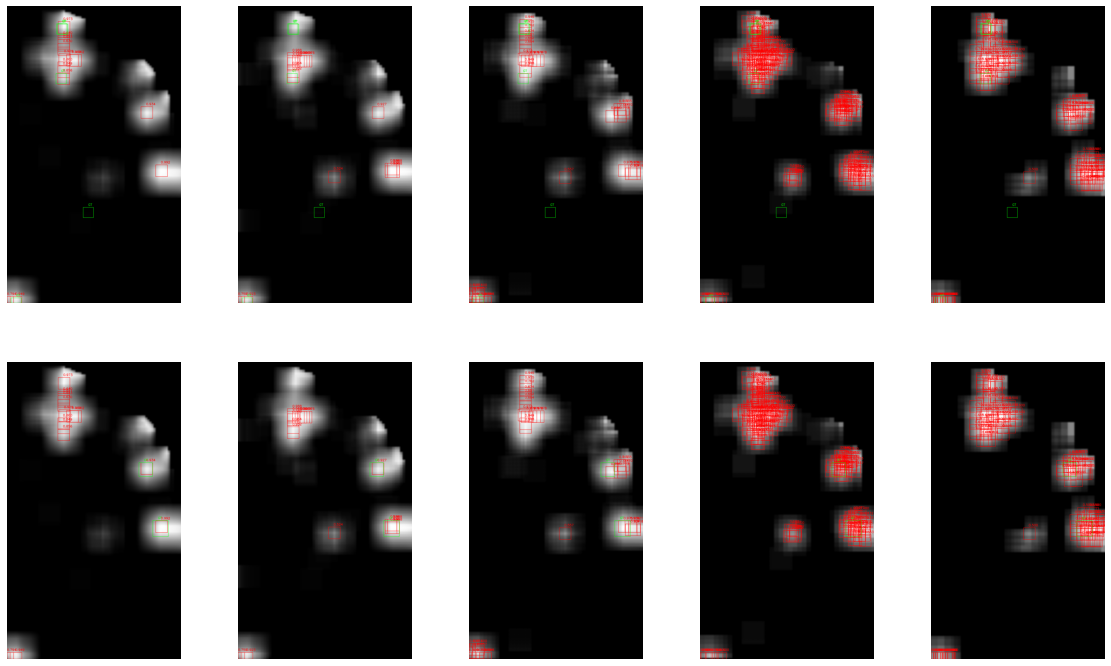

In [8]:
detector = ClassificationBasedDetector(
    model, threshold=0.4660137891769409, pred_kind='binary', norm_kind='avg',
    post_proc=True, patch_size=224, stride=25, min_breast_fraction_patch=0.5,
    batch_size=24, device=device, nms=True, iou_threshold=0.)

detections = {}
fig, ax = plt.subplots(2, 5, figsize=(20, 12))
for k, stride in enumerate([20, 25, 35, 45, 65], 0):
    detector.stride = stride
    detections[stride] = detector.detect(img)
    plot_detections(detections[stride], detector.saliency_map, k=50, gt_bboxes=sample['lesion_bboxes'], ax=ax[0, k])
    plot_detections(detections[stride], detector.saliency_map, k=50, gt_bboxes=sample['ignored_lesion_bboxes'], ax=ax[1, k])
plt.show()

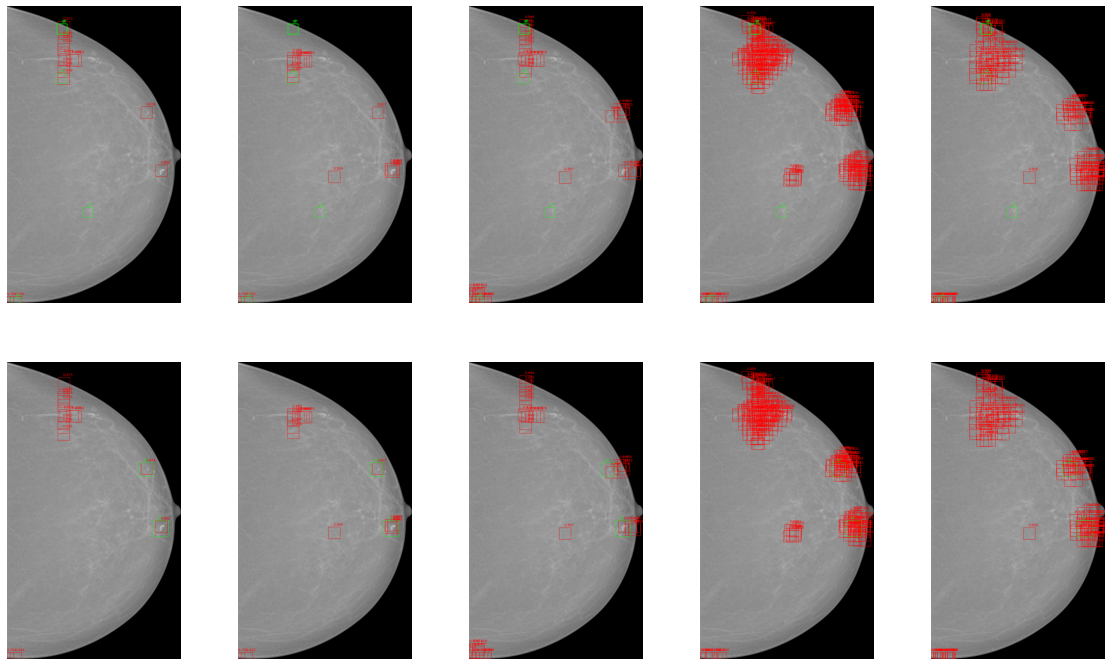

In [9]:
fig, ax = plt.subplots(2, 5, figsize=(20, 12))
for k, (stride, dets) in enumerate(detections.items(), 0):
    plot_detections(dets, img, k=50, gt_bboxes=sample['lesion_bboxes'], ax=ax[0, k])
    plot_detections(dets, img, k=50, gt_bboxes=sample['ignored_lesion_bboxes'], ax=ax[1, k])
plt.show()

100%|██████████| 34/34 [00:04<00:00,  6.89it/s]


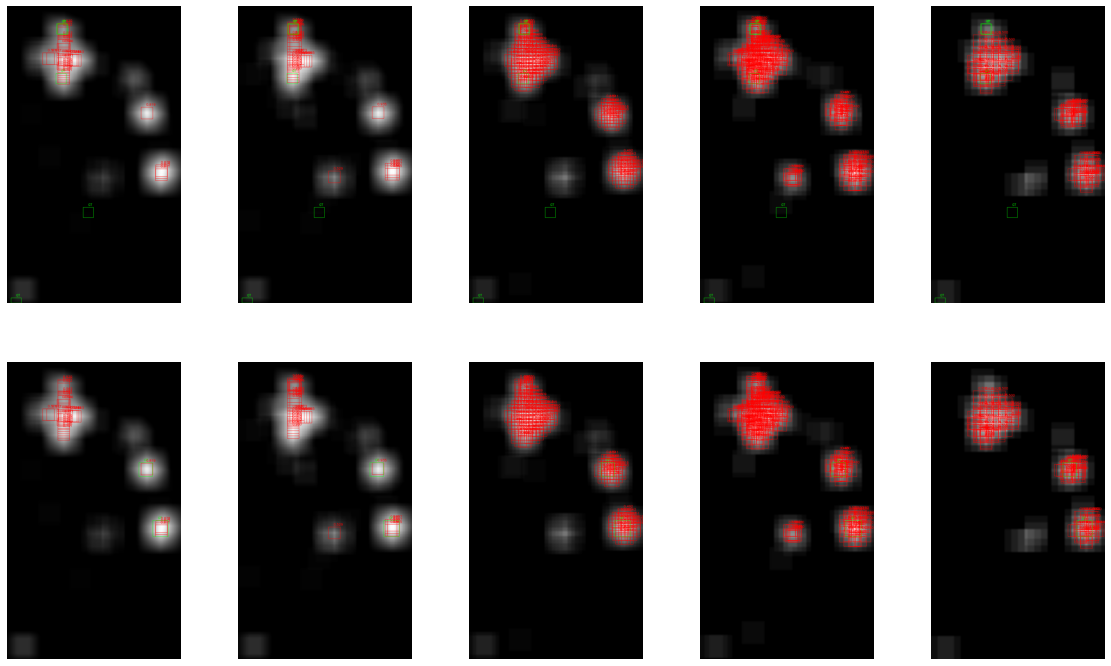

In [10]:
detector = ClassificationBasedDetector(
    model, threshold=0.4660137891769409, pred_kind='binary', norm_kind='min_max',
    post_proc=True, patch_size=224, stride=25, min_breast_fraction_patch=0.5,
    batch_size=24, device=device, nms=True, iou_threshold=0.)

detections = {}
fig, ax = plt.subplots(2, 5, figsize=(20, 12))
for k, stride in enumerate([20, 25, 35, 45, 65], 0):
    detector.stride = stride
    detections[stride] = detector.detect(img)
    plot_detections(detections[stride], detector.saliency_map, k=50, gt_bboxes=sample['lesion_bboxes'], ax=ax[0, k])
    plot_detections(detections[stride], detector.saliency_map, k=50, gt_bboxes=sample['ignored_lesion_bboxes'], ax=ax[1, k])
plt.show()

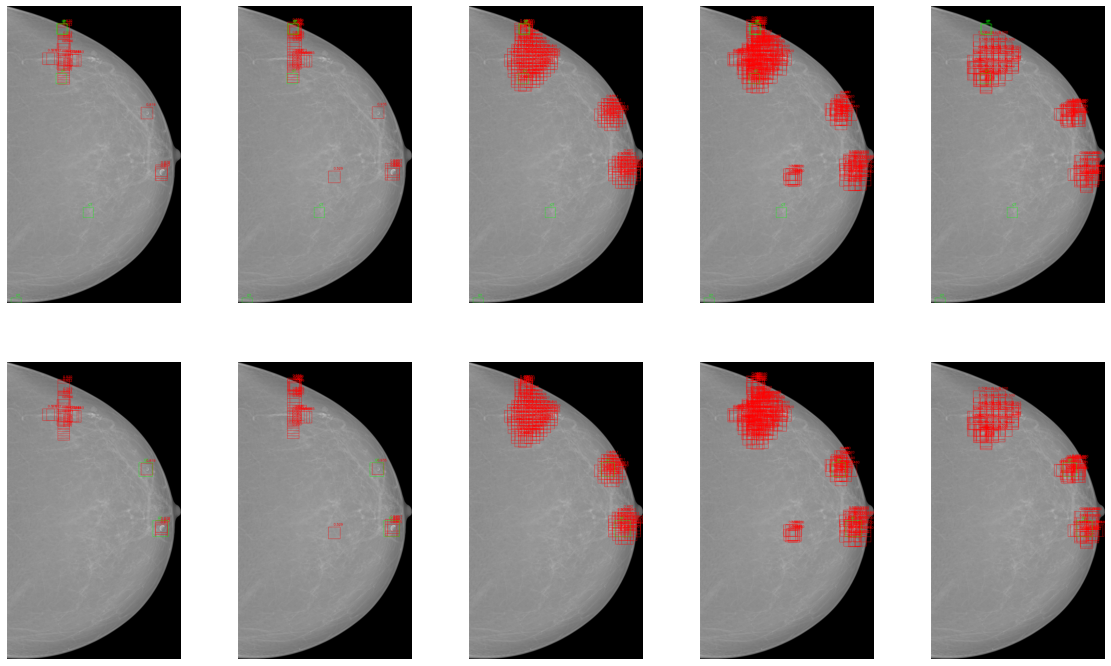

In [11]:
fig, ax = plt.subplots(2, 5, figsize=(20, 12))
for k, (stride, dets) in enumerate(detections.items(), 0):
    plot_detections(dets, img, k=50, gt_bboxes=sample['lesion_bboxes'], ax=ax[0, k])
    plot_detections(dets, img, k=50, gt_bboxes=sample['ignored_lesion_bboxes'], ax=ax[1, k])
plt.show()

#### Effect of threshold

100%|██████████| 343/343 [00:47<00:00,  7.30it/s]


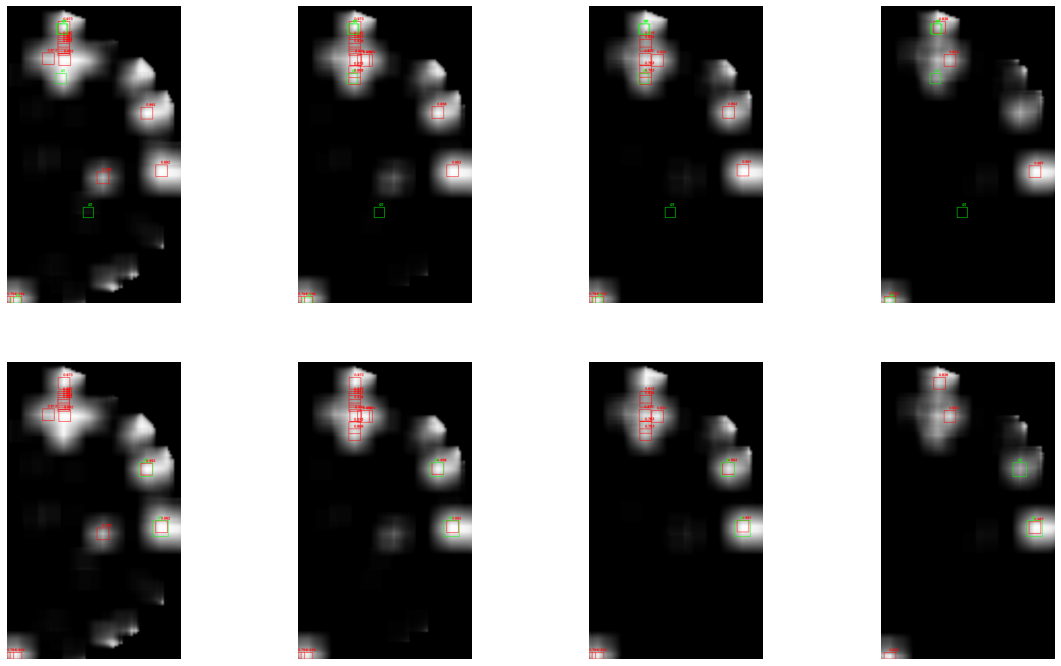

In [6]:
detector = ClassificationBasedDetector(
    model, threshold=0.4660137891769409, pred_kind='binary', norm_kind='avg',
    post_proc=True, patch_size=224, stride=20, min_breast_fraction_patch=0.5,
    batch_size=24, device=device, nms=True, iou_threshold=0.)

detections = {}
fig, ax = plt.subplots(2, 4, figsize=(20, 12))
for k, threshold in enumerate([0.2, 0.4, 0.6, 0.8], 0):
    detector.threshold = threshold
    detections[threshold] = detector.detect(img)
    plot_detections(detections[threshold], detector.saliency_map, k=50, gt_bboxes=sample['lesion_bboxes'], ax=ax[0, k])
    plot_detections(detections[threshold], detector.saliency_map, k=50, gt_bboxes=sample['ignored_lesion_bboxes'], ax=ax[1, k])
plt.show()

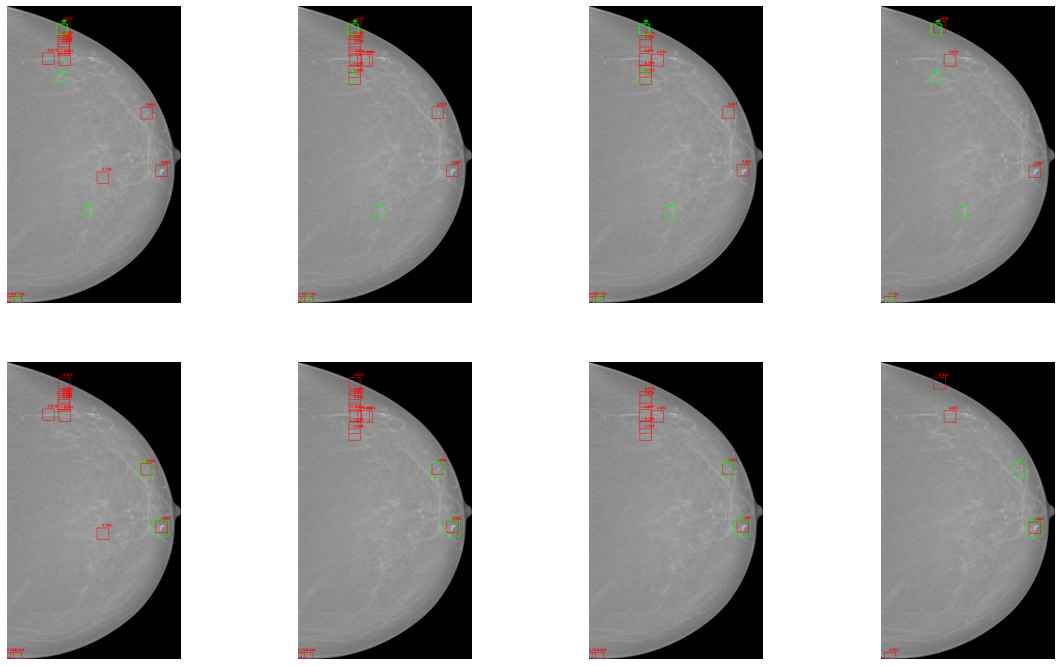

In [7]:
fig, ax = plt.subplots(2, 4, figsize=(20, 12))
for k, (stride, dets) in enumerate(detections.items(), 0):
    plot_detections(dets, img, k=50, gt_bboxes=sample['lesion_bboxes'], ax=ax[0, k])
    plot_detections(dets, img, k=50, gt_bboxes=sample['ignored_lesion_bboxes'], ax=ax[1, k])
plt.show()